In [1]:
# Samuel Grant 2024
# Originally based on Dave Brown's CompCRV.C 

# External
import os
import sys
import math
import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.ticker import ScalarFormatter
from scipy import stats
from scipy.optimize import curve_fit

# Internal
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut
import PrintUtils as pr

In [2]:
# Get data
fileName="/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00038/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000006.root"
finTag = fileName.split('.')[-2] 
with uproot.open(fileName) as file:
    data_ = ut.GetData(file)

In [3]:
def MarkTrackerCuts(arrays_, triggerMode="default", quiet=False):

    if triggerMode in ["crv_trigger", "crv2_trigger", "crv3_trigger"]:
        return 
    
    if not quiet: print(f"\n---> Marking tracker cuts.") 

    # Mark cuts on the track and track fit level
    arrays_["trkfit_KLCRV1"] = ( 
        (arrays_["trkfit"]["klfit"]["sid"] == 200) 
        & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

    arrays_["trk_bestFit"] = ( 
        (arrays_["trk"]["kl.ndof"] >= 10)
        & (arrays_["trk"]["kl.fitcon"] > 0.1)
        & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
        & (arrays_["trk"]["kl.nplanes"] >= 4)
        & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
    arrays_["trkfit_bestFit"] = ( 
        (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
        & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
        & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
        & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )
    
    # Measurement module
    arrays_["trkfit_CRV1Fiducial"] = ( 
        (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) < 6100/2) 
        & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) < 3423/2))

    # Trigger modules
    arrays_["trkfit_CRV23Fiducial"] = ( 
        (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) < 3388/2)
        & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) < 2570/2) ) 

    # CRV-DS 
    arrays_["trkfit_CRV2Fiducial"] = ( 
        (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) < 1525/2)
        & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) < 2570/2) ) 

    # CRV-L-end
    arrays_["trkfit_CRV3Fiducial"] = ( 
        (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) < 3388/2)
        & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) < 1775/2) ) 

    ################################################
    
    # Track condition 
    arrays_["pass_trk"] = arrays_["trk_bestFit"]

    # Track fit (segments) condition (default has no area cut)
    if triggerMode == "default":
        arrays_["pass_trkfit"] = (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])
    elif triggerMode == "trk_crv_trigger":
        arrays_["pass_trkfit"] = (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV23Fiducial"])
    elif triggerMode == "trk_crv2_trigger":
        arrays_["pass_trkfit"] = (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV2Fiducial"])
    elif triggerMode == "trk_crv3_trigger":
        arrays_["pass_trkfit"] = (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV3Fiducial"]) 
    elif triggerMode == "trk_trigger":
        arrays_["pass_trkfit"] = (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV1Fiducial"]) 
    else:
        raise ValueError(f"---> triggerMode '{triggerMode}' not valid...")

    if not quiet: print(f"\nDone.") 
        
    return

In [4]:
MarkTrackerCuts(data_)


---> Marking tracker cuts.

Done.


In [5]:
def ApplyTrackerCuts(arrays_, fail=False, quiet=False): 

    if not quiet: print(f"\n---> Applying tracker cuts") 

    # Mask the data on trk/trkfit level
    if not fail: 
        arrays_["trk"] = arrays_["trk"][arrays_["pass_trk"]] 
        arrays_["trkfit"] = arrays_["trkfit"][arrays_["pass_trkfit"]]
    else: 
        arrays_["trk"] = arrays_["trk"][~arrays_["pass_trk"]] 
        arrays_["trkfit"] = arrays_["trkfit"][~arrays_["pass_trkfit"]]

    # Now clean up empty events after cuts
    goodTrk = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) == True
    # goodTrkFit = (
    #     (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
    #     & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) 
    # )
    goodTrkFit = (
        (ak.any(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) == True) 
        & (ak.any(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) == True) 
    )
    # Reset to event level
    goodTrkFit = ak.any(goodTrkFit, axis=-1, keepdims=False) == True 

    if not quiet: print(f"\nDone.") 
        
    return arrays_[ (goodTrk & goodTrkFit) ]    

In [6]:
track_cuts_ = ak.copy(data_)
track_cuts_ = ApplyTrackerCuts(track_cuts_) 


---> Applying tracker cuts

Done.


In [7]:
withCRV_ = ak.copy(track_cuts_)
noCRV_ = ak.copy(track_cuts_)

# CRV hits
withCRV_ = withCRV_[ak.any(withCRV_["crv"]["crvcoincs.nHits"], axis=1, keepdims=False) == True]
noCRV_ = noCRV_[ak.any(noCRV_["crv"]["crvcoincs.nHits"], axis=1, keepdims=False) == False]

In [8]:
def Plot2DOverlaySideBySide(side_by_side_hists_, nbinsX=100, xmin=None, xmax=None, nbinsY=100, ymin=None, ymax=None
                            , xlabels_=None, ylabels_=None, fout="hist_side_by_side.png"
                            , min_box_coords=None, max_box_coords=None, box_colour="w"
                            , log=False, cb=True, NDPI=300, legPos="best", includeBlack=False, legFontSize=12):
    
    
    # Create figure and axes (subplots side by side)
    num_hists = len(side_by_side_hists_)
    fig, axs_ = plt.subplots(1, num_hists, figsize=(6 * num_hists, 6), sharey=True)
    # Iterate over the histograms and axes
    for i, (data, ax) in enumerate(zip(side_by_side_hists_, axs_)):
        x, y, label = data

        # Filter out empty entries from x and y
        valid_indices = [i for i in range(len(x)) if np.any(x[i]) and np.any(y[i])]

        # Extract valid data points based on the indices
        x = [x[i] for i in valid_indices]
        y = [y[i] for i in valid_indices]

        # Create 2D histogram
        hist, x_edges, y_edges = np.histogram2d(x, y, bins=[nbinsX, nbinsY], range=[[xmin, xmax], [ymin, ymax]])

        # Set normalization
        norm = colors.Normalize(vmin=0, vmax=np.max(hist))
        if log:
            norm = colors.LogNorm(vmin=1, vmax=np.max(hist))
        
        # Plot 2D histogram
        im = ax.imshow(hist.T, cmap='inferno', extent=[xmin, xmax, ymin, ymax], aspect='auto', origin='lower', norm=norm)
        
        # Add colorbar if needed
        if cb: # and i == num_hists - 1:
            cbar = plt.colorbar(im, ax=ax)
            cbar.ax.tick_params(labelsize=14)

        # Draw a box if min_box_coords and max_box_coords are provided
        if min_box_coords and max_box_coords:
            x_min, y_min = min_box_coords
            x_max, y_max = max_box_coords
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, linestyle="--", edgecolor=box_colour, facecolor="none")
            ax.add_patch(rect)
        
        # Set axis labels and titles
        ax.set_xlabel(xlabels_[i], fontsize=14, labelpad=10)
        if len(set(ylabels_)) == 1:
            if i == 0:
                ax.set_ylabel(ylabels_[i], fontsize=14, labelpad=10)
        else:
            ax.set_ylabel(ylabels_[i], fontsize=14, labelpad=10)
        
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        ax.set_ylim(ymin, ymax)
        ax.set_xlim(xmin, xmax)
        # ax.tick_params(axis='z', labelsize=14)
        
        # Set title and legend
        ax.set_title(label, fontsize=16, pad=10)
    
    plt.tight_layout()
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    plt.show()
    
    # Clear memory
    plt.close()
    
    print("\n---> Written:\n\t", fout)

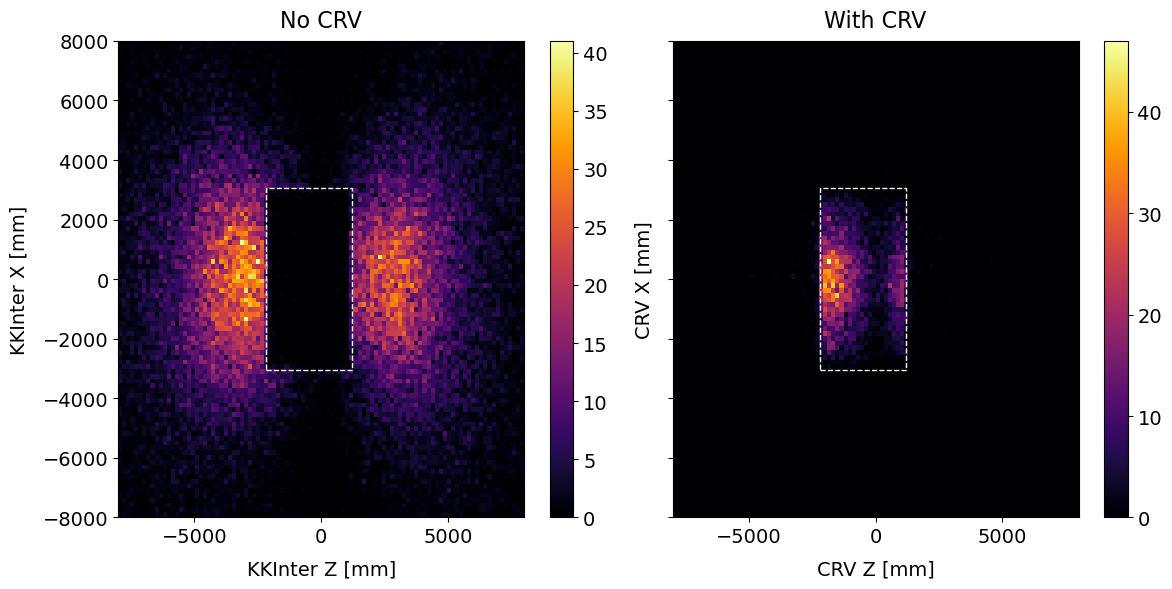


---> Written:
	 ../Images/MDC2020ae/CompCRV/h2_sbs_XZ_no_with_CRV.png


In [9]:
side_by_side_hists_ = [
    (ak.flatten(noCRV_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None), ak.flatten(noCRV_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None), "No CRV")
    ,(ak.flatten(withCRV_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None), ak.flatten(withCRV_["crv"]["crvcoincs.pos.fCoordinates.fX"], axis=None), "With CRV")
]

min_box_coords = (-3388/2-500, -6100/2)
max_box_coords = (3388/2-500, 6100/2)

Plot2DOverlaySideBySide(
    side_by_side_hists_=side_by_side_hists_,
    nbinsX=100,
    xmin=-8000, xmax=8000,
    nbinsY=100,
    ymin=-8000, ymax=8000,
    min_box_coords=min_box_coords, max_box_coords=max_box_coords,
    xlabels_=["KKInter Z [mm]", "CRV Z [mm]"],
    ylabels_=["KKInter X [mm]", "CRV X [mm]"],
    fout=f"../Images/MDC2020ae/CompCRV/h2_sbs_XZ_no_with_CRV.png",
    log=False,
    cb=True,
    NDPI=300,
    legFontSize=12
)

In [15]:
# deltaT histograms

# We need one track segment per coincidence...
# So we want events with one coincidence in the CRV-T, with a single good track segment passing through the CRV-T plane.

# track_cuts_ = ak.copy(data_) 

# # Select good tracks passing extrapolating back to the CRV-T
# track_cuts_ = ApplyTrackerCuts(track_cuts_)

# Interesting event
# subRunCondition = track_cuts_["evt"]["evtinfo.subrun"] == 1578 
# eventCondition = track_cuts_["evt"]["evtinfo.event"] == 420858

# Require one track per event
track_cuts_ = track_cuts_[ak.count(track_cuts_["trk"]["kl.status"], axis=1, keepdims=False) == 1] 

# # Require one track segment per event
track_cuts_ = track_cuts_[ak.any((ak.count(track_cuts_["trkfit"]["klfit"]["sid"], axis=1, keepdims=False) == 1), axis=1, keepdims=False) == True] 

# Mask non-CRV-T coincidences 
track_cuts_["crv"] = track_cuts_["crv"][track_cuts_["crv"]["crvcoincs.sectorType"] == 1] 

# Require one CRV-T coincidence per event 
track_cuts_ = track_cuts_[ak.sum(track_cuts_["crv"]["crvcoincs.sectorType"], axis=1, keepdims=False) == 1] 

nTrkSegs = len(ak.flatten(track_cuts_["trkfit"]["klfit"]["time"], axis=None))
nCoin = len(ak.flatten(track_cuts_["crv"]["crvcoincs.time"], axis=None))

if nTrkSegs != nCoin: 
    raise ValueError(f"Number of track segments does not match the number of CRV coincidences. {nTrkSegs} != {nCoin}")
    
# Construct deltaT 
deltaT_ = ak.flatten(track_cuts_["trkfit"]["klfit"]["time"], axis=None) - ak.flatten(track_cuts_["crv"]["crvcoincs.time"], axis=None)

In [19]:
trkX_ = ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
trkZ_ = ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
crvX_ = ak.flatten(track_cuts_["crv"]["crvcoincs.pos.fCoordinates.fX"], axis=None)
crvZ_ = ak.flatten(track_cuts_["crv"]["crvcoincs.pos.fCoordinates.fZ"], axis=None)

---> Written ../Images/MDC2020ae/CompCRV/h12_deltaT.png


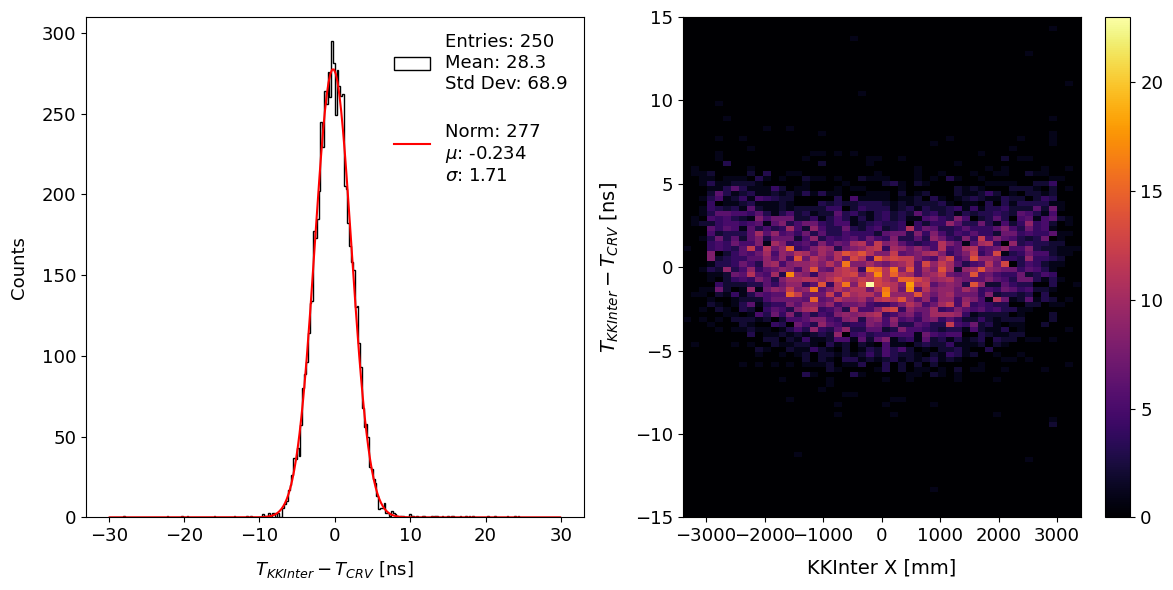

In [23]:
# Plot deltaT histograms

# Plot side-by-side
fig, ax = plt.subplots(1,2, figsize=(12, 6))

nbins=250
xmin=-30
xmax=30
counts, binEdges, _ = ax[0].hist(deltaT_, bins=250, range=(xmin, xmax), histtype='step', edgecolor='black', linewidth=1.0, fill=False, density=False)

##########################
# Construct & fit gaussian
#########################

# Calculate bin centers
binCentres = ut.GetBinCentres(binEdges) 

# Filter bin_centres and counts based on fitMin and fitMax
fitMin=-30
fitMax=30
valid = (binCentres >= fitMin) & (binCentres <= fitMax)
binCentresFit = binCentres[valid]
countsFit = counts[valid]

# Fit the Gaussian function to the histogram data
params, covariance = curve_fit(ut.GausFunc, binCentresFit, countsFit, p0=[300, 0, 3])
# Extract parameters from the fitting
norm, mu, sigma = params
# Plot the Gaussian curve
ax[0].plot(binCentresFit, ut.GausFunc(binCentresFit, norm, mu, sigma), color="red")

# Calculate statistics
N, mean, meanErr, stdDev, stdDevErr, underflows, overflows = ut.GetBasicStats(counts, xmin, xmax)

# Create legend text
legendText = [f"Entries: {N}\nMean: {ut.Round(mean, 3)}\nStd Dev: {ut.Round(stdDev, 3)}", f"\nNorm: {ut.Round(norm,3)}\n" + r"$\mu$" + f": {ut.Round(mu,3)}\n" + r"$\sigma$" f": {ut.Round(sigma, 3)}"]

ax[0].legend(legendText, loc="best", frameon=False, fontsize=13)

# ax[0].set_title(title, fontsize=15, pad=10)
ax[0].set_xlabel(r"$T_{KKInter} - T_{CRV}$ [ns]", fontsize=13, labelpad=10) 
ax[0].set_ylabel("Counts", fontsize=13, labelpad=10) 

# Set font size of tick labels on x and y axes
ax[0].tick_params(axis='x', labelsize=13)  # Set x-axis tick label font size
ax[0].tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size

# Scientific notation
ut.ScientificNotation(ax[0]) 

#################
# Right histogram
h2_XdT = ut.Hist2D(x=trkX_, y=deltaT_, nbinsX=50, xmin=-3400, xmax=3400, nbinsY=100, ymin=-15, ymax=15)

extent = [-3400, 3400, -15, 15]
im = ax[1].imshow(h2_XdT.T, cmap="inferno", extent=extent, aspect="auto", origin="lower")

cb = fig.colorbar(im)

ax[1].set_xlabel("KKInter X [mm]", fontsize=14, labelpad=10)
ax[1].set_ylabel(r"$T_{KKInter} - T_{CRV}$ [ns]", fontsize=14, labelpad=10)

# Set font size of tick labels on x and y axes
ax[1].tick_params(axis='both', labelsize=13)  
cb.ax.tick_params(labelsize=13) 
fig.tight_layout()
fig.show()

fout="../Images/MDC2020ae/CompCRV/h12_deltaT.png"
fig.savefig(fout, dpi=300, bbox_inches="tight")

print(f"---> Written {fout}")

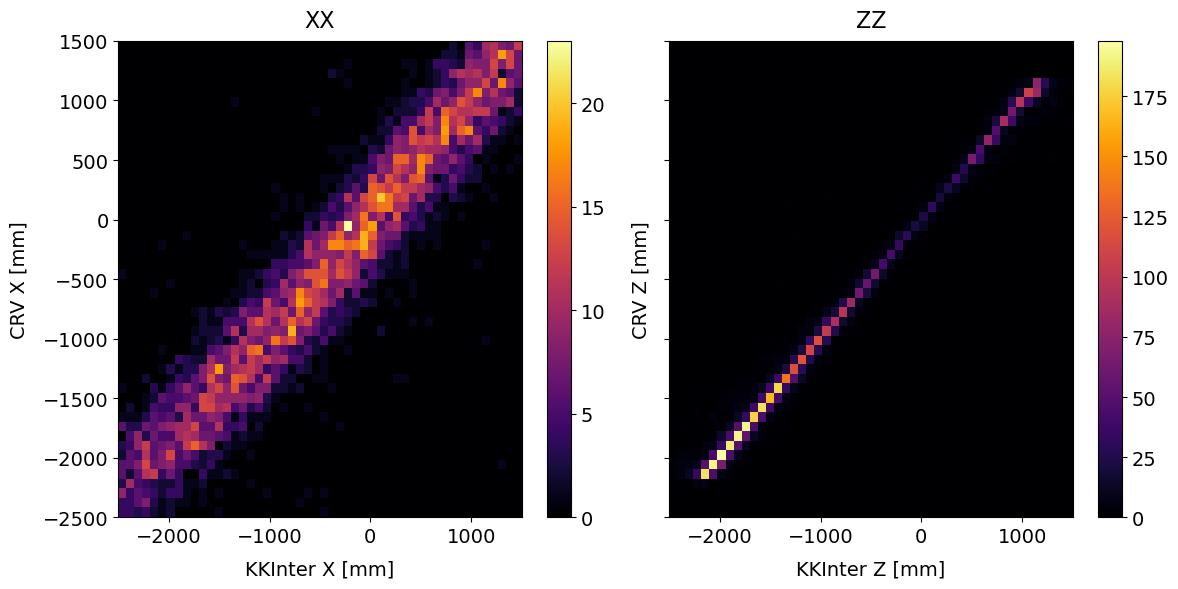


---> Written:
	 ../Images/MDC2020ae/CompCRV/h2_sbs_trkCRV_XX_ZZ.png


In [26]:
# XX and ZZ trk-crv histograms

side_by_side_hists_ = [
    (trkX, crvX, "XX")
    ,(trkZ, crvZ, "ZZ") 
]

# min_box_coords = (-3388/2-500, -6100/2)
# max_box_coords = (3388/2-500, 6100/2)

Plot2DOverlaySideBySide(
    side_by_side_hists_=side_by_side_hists_,
    nbinsX=50,
    xmin=-2500, xmax=1500,
    nbinsY=50,
    ymin=-2500, ymax=1500,
    # min_box_coords=min_box_coords, max_box_coords=max_box_coords,
    xlabels_=["KKInter X [mm]", "KKInter Z [mm]"],
    ylabels_=["CRV X [mm]", "CRV Z [mm]"],
    fout=f"../Images/MDC2020ae/CompCRV/h2_sbs_trkCRV_XX_ZZ.png",
    log=False,
    cb=True,
    NDPI=300,
    legFontSize=12
)

In [27]:
# fig, ax = plt.subplots(1,2, figsize=(12, 6))

# h2_XX = Hist2D(x=trkZ, y=crvZ, nbinsX=50, xmin=-2500, xmax=1500, nbinsY=50, ymin=-2500, ymax=1500)
# h2_ZZ = Hist2D(x=trkX, y=crvX, nbinsX=50, xmin=-3400, xmax=3400, nbinsY=50, ymin=-3400, ymax=3400)

# im1 = ax[0].imshow(h2_XX.T, cmap="inferno", extent=[-2500, 1500, -2500, 1500], aspect="auto", origin="lower")
# im2 = ax[1].imshow(h2_ZZ.T, cmap="inferno", extent=[-3400, 3400, -3400, 3400], aspect="auto", origin="lower")

# cb0 = fig.colorbar(im1)
# cb1 = fig.colorbar(im2)

# # ScientificNotation(ax[0])
# # ScientificNotation(ax[1])

# ax[0].set_title("With coincidence", fontsize=16, pad=10)
# ax[0].set_xlabel("KKInter Z [mm]", fontsize=14, labelpad=10)
# ax[0].set_ylabel("CRV Z [mm]", fontsize=14, labelpad=10)

# ax[1].set_title("No coincidence", fontsize=16, pad=10)
# ax[1].set_xlabel("KKInter X [mm]", fontsize=14, labelpad=10)
# ax[1].set_ylabel("CRV X [mm]", fontsize=14, labelpad=10)

# # Set font size of tick labels on x and y axes
# ax[0].tick_params(axis='both', labelsize=13) 
# ax[1].tick_params(axis='both', labelsize=13)  
# cb0.ax.tick_params(labelsize=13) 
# cb1.ax.tick_params(labelsize=13)  

# fig.tight_layout()
# fig.show()

# fout="Images/MDC2020ae/CompCRV/h2_XX_ZZ.png"
# fig.savefig(fout, dpi=300, bbox_inches="tight")
# print(f"---> Written {fout}")

In [ ]:
# # XZ histograms
# # Plot side-by-side
# fig, ax = plt.subplots(1,2, figsize=(12, 6))

# h2_ZX_withCRV = Hist2D(x=ak.flatten(withCRV["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
#                        , y=ak.flatten(withCRV["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
#                        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000) 
# h2_ZX_noCRV = Hist2D(x=ak.flatten(noCRV["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
#                      , y=ak.flatten(noCRV["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
#                      , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000)

# extent = [-8000, 8000, -8000, 8000]

# im1 = ax[0].imshow(h2_ZX_withCRV.T, cmap="inferno", extent=extent, aspect="auto", origin="lower")
# im2 = ax[1].imshow(h2_ZX_noCRV.T, cmap="inferno", extent=extent, aspect="auto", origin="lower")

# cb0 = fig.colorbar(im1)
# cb1 = fig.colorbar(im2)

# # ScientificNotation(ax[0])
# # ScientificNotation(ax[1])

# ax[0].set_title("With coincidence", fontsize=16, pad=10)
# ax[0].set_xlabel("KKInter Z [mm]", fontsize=14, labelpad=10)
# ax[0].set_ylabel("KKInter X [mm]", fontsize=14, labelpad=10)

# ax[1].set_title("No coincidence", fontsize=16, pad=10)
# ax[1].set_xlabel("KKInter Z [mm]", fontsize=14, labelpad=10)
# ax[1].set_ylabel("KKInter X [mm]", fontsize=14, labelpad=10)

# # Set font size of tick labels on x and y axes
# ax[0].tick_params(axis='both', labelsize=13) 
# ax[1].tick_params(axis='both', labelsize=13)  
# cb0.ax.tick_params(labelsize=13) 
# cb1.ax.tick_params(labelsize=13)  

# fig.tight_layout()
# fig.show()

# fout="Images/h2_ZX.png"
# fig.savefig(fout, dpi=300, bbox_inches="tight")
# print(f"---> Written {fout}")

In [ ]:
# # Sanity check
# # ---> tcrvpg->GetEntries()	6614
# # ---> tcrvpb->GetEntries()	47728
# print(h2_ZX_withCRV.sum())
# print(h2_ZX_noCRV.sum())
# # I get slightly more entries, why? 
# # 15% and 5% more... 
# # Need to plot the invidual cuts. A job for a different notebook. 
# # Is this within the range of the histogram?

In [ ]:
# More plotting

# I have to ensure that we only have one CRV1 hit, or else the arrays are different lengths and cannot be subtracted. 
# I feel like ROOT just throws a warning when this happens... 

# track_cuts_ = ApplyCuts(withCRV, ["singleCRV1"])

# Variables for plotting below
# deltaT = ak.flatten(track_cuts_["klfit"]["time"], axis=None) - ak.flatten(track_cuts_["crvcoincs"]["crvcoincs.time"], axis=None)
# trkX = ak.flatten(track_cuts_["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
# trkZ = ak.flatten(track_cuts_["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
# crvX = ak.flatten(track_cuts_["crvcoincs"]["crvcoincs.pos.fCoordinates.fX"], axis=None)
# crvZ = ak.flatten(track_cuts_["crvcoincs"]["crvcoincs.pos.fCoordinates.fZ"], axis=None)

In [ ]:
# # Sanity check
# # ---> tcrvts->GetEntries()	6614
# # ---> dtvx->GetEntries()	6614
# print(counts.sum())
# print(h2_XdT.sum())
# # I get slightly more entries, why? 
# # 15% and 5% more... 
# # Need to plot the invidual cuts. A job for a different notebook. 
# # Is this within the range of the histogram?

In [ ]:
# Sanity check
# ---> zvz->GetEntries()	6614
# ---> xvx->GetEntries()	6614
# print(h2_XX.sum())
# print(h2_ZZ.sum())

In [ ]:
# # goodCRV
# Plot1D(ak.flatten(withCRV["crvcoincs"]["crvcoincs.nHits"], axis=None), nbins=10, xmin=0, xmax=10, xlabel="crvcoincs.nHits", ylabel="Coincidiences", title="$>0$", fout="Images/cut_crvcoincs.nHits.png")
# # Plot1D(ak.flatten(withCRV["crvcoincs"]["crvcoincs.nHits"], axis=None), nbins=1, xmin=0, xmax=1, xlabel="Hits / coincidence", ylabel="Coincidiences", title="Good CRV")
# # Plot1D(ak.flatten(arrays["crvcoincs"]["crvcoincs.nHits"], axis=None), nbins=10, xmin=0, xmax=10, xlabel="Hits / coincidence", ylabel="Coincidiences", title="All")


In [ ]:
# # goodTrk
# Plot1D(ak.flatten(withCRV["kl"]["kl.status"], axis=None), nbins=2, xmin=0, xmax=2, xlabel="kl.status", ylabel="Tracks", title="$=1$", fout="Images/cut_kl.status.png")

In [ ]:
# # CRV1 
# Plot1D(ak.flatten(withCRV["crvcoincs"]["crvcoincs.sectorType"], axis=None), nbins=4, xmin=0, xmax=4, xlabel="crvcoincs.sectorType", ylabel="Coincidences", title="$=1$", fout="Images/cut_crvcoincs.sectorType.png")

In [ ]:
# # KLCRV1
# Plot1D(ak.flatten(withCRV["klfit"]["sid"], axis=None), nbins=500, xmin=0, xmax=500, xlabel="klfit.SID", ylabel="Tracks", title="$=200$", fout="Images/cut_klfit.SID.png")
# Plot1D(ak.flatten(withCRV["klfit"]["sindex"], axis=None), nbins=10, xmin=0, xmax=10, xlabel="klfit.sindex", ylabel="Tracks", title="$=1$", fout="Images/cut_klfit.sindex.png")

In [ ]:
# # kl.bestFit
# # arrays["kl.bestFit"] = ( (arrays["kl"]["kl.ndof"] >= 10)
# #                                 & (arrays["kl"]["kl.fitcon"] > 0.1)
# #                                 & ((arrays["kl"]["kl.nactive"]/arrays["kl"]["kl.nhits"]) > 0.99)
# #                                 & (arrays["kl"]["kl.nplanes"] >= 4)
# #                                 & ((arrays["kl"]["kl.nnullambig"]/arrays["kl"]["kl.nhits"]) < 0.2) )

# Plot1D(ak.flatten(withCRV["kl"]["kl.ndof"], axis=None), nbins=500, xmin=0, xmax=50, xlabel="kl.ndof", ylabel="Tracks", title=r"$\geq10$", fout="Images/cut_kl.ndof.png")
# Plot1D(ak.flatten(withCRV["kl"]["kl.fitcon"], axis=None), nbins=100, xmin=0, xmax=1.0, xlabel="kl.fitcon", ylabel="Tracks", title="$> 0.1$", fout="Images/cut_kl.fitcon.png")
# Plot1D(ak.flatten((withCRV["kl"]["kl.nactive"]/withCRV["kl"]["kl.nhits"]), axis=None), nbins=200, xmin=0, xmax=2.0, xlabel="kl.nactive/kl.nhits", ylabel="Tracks", title="$> 0.99$", fout="Images/cut_kl.nactive_kl.nhits.png")
# Plot1D(ak.flatten(withCRV["kl"]["kl.nplanes"], axis=None), nbins=100, xmin=0, xmax=10, xlabel="kl.nplanes", ylabel="Tracks", title=r"$\geq 4$", fout="Images/cut_kl.nplanes.png")
# Plot1D(ak.flatten((withCRV["kl"]["kl.nnullambig"]/withCRV["kl"]["kl.nhits"]), axis=None), nbins=50, xmin=0, xmax=0.5, xlabel="kl.nnullambig/kl.nhits", ylabel="Tracks", title="$< 0.2$", fout="Images/cut_kl.nnullambig_kl.nhits.png")

In [ ]:
# # Local bestFit 
# Plot1D(ak.flatten(withCRV["klkl"]["z0err"], axis=None), nbins=150, xmin=0, xmax=1.5, xlabel="[klkl][z0err]", ylabel="Tracks", title=r"$< 1$", fout="Images/cut_klkl.z0err.png")
# # array = ak.flatten(withCRV["klkl"]["z0err"], axis=None)
# # print(np.min(array), np.max(array))
# Plot1D(ak.flatten(withCRV["klkl"]["d0err"], axis=None), nbins=150, xmin=0, xmax=1.5, xlabel="[klkl][d0err]", ylabel="Tracks", title="$< 1$", fout="Images/cut_klkl.d0err.png")
# Plot1D(ak.flatten(withCRV["klkl"]["thetaerr"], axis=None), nbins=100, xmin=0, xmax=.001, xlabel="[klkl][thetaerr]", ylabel="Tracks", title="$< 0.0004$", fout="Images/cut_klkl.thetaerr.png")
# Plot1D(ak.flatten(withCRV["klkl"]["phi0err"], axis=None), nbins=200, xmin=0, xmax=0.002, xlabel="[klkl][phi0err]", ylabel="Tracks", title=r"$< 0.001$", fout="Images/cut_klkl.phi0err.png")